In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout
from scikeras.wrappers import KerasRegressor

In [28]:
df = pd.read_csv("Predict_ready_df")

In [29]:
df.drop(df[df['idle_time']==0].index,inplace= True)

In [30]:
df

,Unnamed: 0,timestamp,station_id,bike_id,idle_time,bike_count,temperature,windspeed,rain,hour,IsWeekday,month,lat,lon,near_bus_station,near_school,near_leisure_spots
0,1,2019-01-01 09:00:00,3,2191,113.283333,1,10.0,30.0,0,9,1,1,37.78638,-122.40490,0,0,1
1,2,2019-01-01 09:00:00,3,5063,107.800000,2,10.0,30.0,0,9,1,1,37.78638,-122.40490,0,0,1
2,3,2019-01-01 09:00:00,3,5262,98.400000,3,10.0,30.0,0,9,1,1,37.78638,-122.40490,0,0,1
3,4,2019-01-01 10:00:00,3,5354,31.116667,4,9.0,37.0,0,10,1,1,37.78638,-122.40490,0,0,1
4,5,2019-01-01 10:00:00,3,4760,25.700000,5,9.0,37.0,0,10,1,1,37.78638,-122.40490,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130983,3132765,2019-12-23 17:00:00,498,12424,1.083333,2,10.0,6.0,0,17,1,12,37.72589,-122.45244,0,1,1
3130984,3132766,2019-12-23 17:00:00,498,353685,975.483333,2,10.0,6.0,0,17,1,12,37.72589,-122.45244,0,1,1
3130985,3132767,2019-12-24 10:00:00,498,10310,196.016667,2,8.0,15.0,0,10,1,12,37.72589,-122.45244,0,1,1
3130986,3132768,2019-12-30 14:00:00,498,10962,0.383333,1,9.0,11.0,0,14,1,12,37.72589,-122.45244,0,1,1


# Transform cyclic features

In [31]:
df.timestamp = pd.to_datetime(df['timestamp'],format ='%Y-%m-%d %H:%M:%S')

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
start_date = '2019-01-01'
end_date = '2019-12-31'
holidays = cal.holidays(start=start_date, end=end_date)



In [33]:
df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day

# Create a new 'date' column with the timestamp
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [34]:
df['IsHoliday'] = (df['date'].isin(holidays)).astype(int)

In [35]:
df.drop(['year','day'],axis = 1,inplace= True)

In [36]:

from sklearn.preprocessing import OneHotEncoder


# Define the mapping of months to seasons
season_mapping = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn',
    12: 'Winter'
}

# Map the month values to seasons using the defined mapping
df['season'] = df['month'].map(season_mapping)

# Perform one-hot encoding on the 'season' column
encoder = OneHotEncoder(sparse=False)
df['season'] = encoder.fit_transform(df[['season']])






c:\Users\riven\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [37]:
hour_dummy =pd.get_dummies(df.hour, prefix ="hour")

In [38]:
df = pd.concat([hour_dummy,df],axis = 1)

In [39]:
df

,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,...,IsWeekday,month,lat,lon,near_bus_station,near_school,near_leisure_spots,date,IsHoliday,season
0,0,0,0,0,0,0,0,0,0,1,...,1,1,37.78638,-122.40490,0,0,1,2019-01-01,1,0.0
1,0,0,0,0,0,0,0,0,0,1,...,1,1,37.78638,-122.40490,0,0,1,2019-01-01,1,0.0
2,0,0,0,0,0,0,0,0,0,1,...,1,1,37.78638,-122.40490,0,0,1,2019-01-01,1,0.0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,37.78638,-122.40490,0,0,1,2019-01-01,1,0.0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,37.78638,-122.40490,0,0,1,2019-01-01,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3130983,0,0,0,0,0,0,0,0,0,0,...,1,12,37.72589,-122.45244,0,1,1,2019-12-23,0,0.0
3130984,0,0,0,0,0,0,0,0,0,0,...,1,12,37.72589,-122.45244,0,1,1,2019-12-23,0,0.0
3130985,0,0,0,0,0,0,0,0,0,0,...,1,12,37.72589,-122.45244,0,1,1,2019-12-24,0,0.0
3130986,0,0,0,0,0,0,0,0,0,0,...,1,12,37.72589,-122.45244,0,1,1,2019-12-30,0,0.0


In [41]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

hour_arr = np.array(df['hour'])
month_arr = np.array(df['month'])


df['hour_sin'] = sin_transformer(24).fit_transform(hour_arr.reshape(-1,1))
df['hour_cos'] = cos_transformer(24).fit_transform(hour_arr.reshape(-1,1))
df['month_sin'] = sin_transformer(12).fit_transform(month_arr.reshape(-1,1))
df['month_cos'] = cos_transformer(12).fit_transform(month_arr.reshape(-1,1))


# Remove outlier

In [40]:
# Assuming you have a DataFrame named 'df' and want to remove outliers from column 'column_name'

# Calculate the z-scores for each value in the column
z_scores = np.abs((df['idle_time'] - df['idle_time'].mean()) / df['idle_time'].std())

# Define a threshold for outliers (e.g., z-score > 3)
threshold = 1.5

# Create a boolean mask indicating the outliers
outliers_mask = z_scores > threshold

# Remove outliers from the column by replacing them with NaN values
df.loc[outliers_mask, 'idle_time'] = np.nan

# Return the modified column back to the original DataFrame
df = df.dropna(subset=['idle_time']) # Replace NaN values with median or any other desired method

In [6]:
df.idle_time.min()

0.0166666666666666

In [41]:
df.columns

Index(['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'Unnamed: 0',
       'timestamp', 'station_id', 'bike_id', 'idle_time', 'bike_count',
       'temperature', 'windspeed', 'rain', 'hour', 'IsWeekday', 'month', 'lat',
       'lon', 'near_bus_station', 'near_school', 'near_leisure_spots', 'date',
       'IsHoliday', 'season'],
      dtype='object')

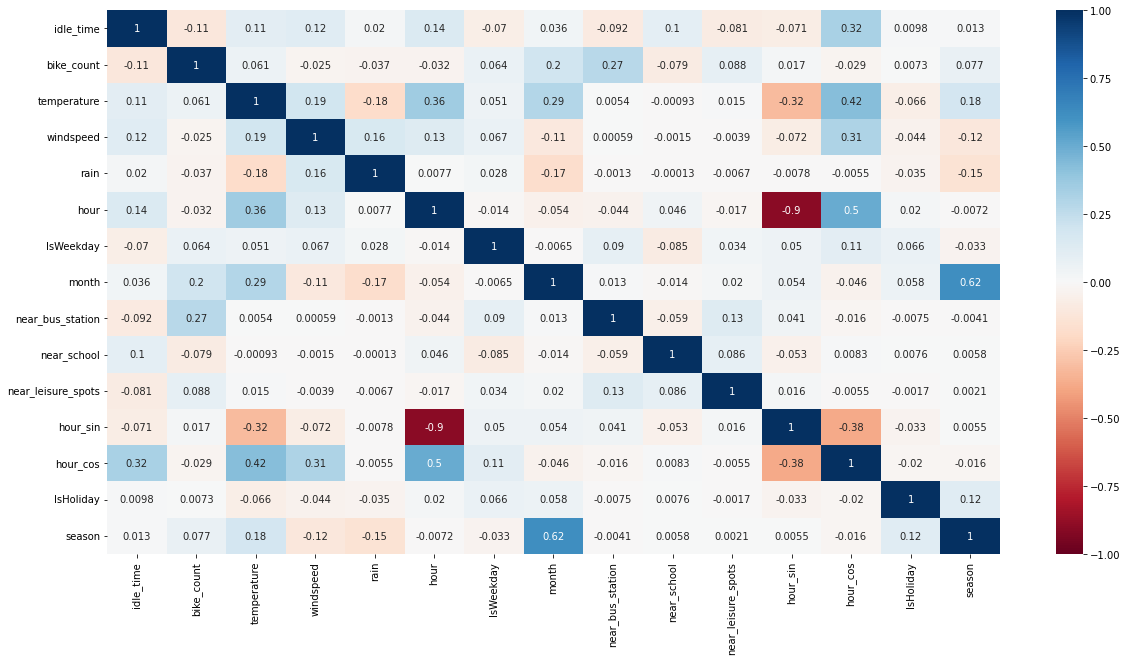

In [44]:
features =['idle_time',
       'bike_count', 'temperature', 'windspeed', 'rain', 'hour', 'IsWeekday',
       'month','near_bus_station', 'near_school',
       'near_leisure_spots', 'hour_sin', 'hour_cos', 'IsHoliday',
       'season']

used = df[features]
plt.figure(figsize=(20, 10))
corr = used.corr()
# Create the heatmap
sns.heatmap(corr, cmap='RdBu', vmin=-1, vmax=1, annot=True)
plt.show()

In [45]:
xp = df[['bike_count', 'temperature', 'windspeed','month_sin','month_cos', 'rain', 'IsWeekday',
       'near_bus_station', 'near_school',
       'near_leisure_spots','IsHoliday','season'
       ]].values

yp= df['idle_time'].values

In [55]:
sample_set = df[[ 'bike_count',
       'temperature', 'windspeed','hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
        'rain','IsWeekday',
       'near_bus_station', 'near_school', 'near_leisure_spots',
       'IsHoliday', 'season','idle_time']].values

In [88]:
sample_size = 10000
random_indices = np.random.choice(sample_set.shape[0], size=sample_size, replace=False)
sample = sample_set[random_indices,:]

xs = sample[:,:34]
ys = sample[:,34:]

In [48]:
X_train_val, X_test, y_train_val, y_test = train_test_split(xp, yp, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)

Scaling features

In [89]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
# X_train[:,:3] = scaler.fit_transform(X_train[:,:3])
# X_test[:,:3] = scaler.transform(X_test[:,:3])
# X_val[:,:3] = scaler.transform(X_val[:,:3])

xs[:,:3] = scaler.fit_transform(xs[:,:3])


In [46]:
xs.shape

(10000, 35)

In [90]:
from sklearn.preprocessing import PolynomialFeatures
degree = 15
poly = PolynomialFeatures(degree= degree,include_bias= False)
# poly_fts_train = poly.fit_transform(X_train[:,:5])
# poly_fts_test = poly.transform(X_test[:,:5])
# poly_fts_val = poly.transform(X_val[:,:5])

poly_fts_xs = poly.fit_transform(xs[:,:3])




In [91]:
# non_poly_train = X_train[:,5:]
# non_poly_test = X_test[:,5:]
# non_poly_val = X_val[:,5:]

non_poly_xs = xs[:,3:]



In [92]:
# poly_train = np.concatenate((poly_fts_train,non_poly_train),axis =1)
# poly_test = np.concatenate((poly_fts_test,non_poly_test),axis =1)
# poly_val = np.concatenate((poly_fts_val,non_poly_val),axis =1)

poly_xs = np.concatenate((poly_fts_xs,non_poly_xs),axis =1)

In [85]:
poly_xs.shape

(10000, 1801)

In [54]:

# define base model

 # create model
model = Sequential()
model.add(Dense(10, input_shape=(126,), kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))
model.add(Dense(10, kernel_initializer='normal', activation='relu'))




model.add(Dense(1, kernel_initializer='normal'))
 # Compile model
model.compile(loss='mean_squared_error', optimizer='adam'
             )


In [55]:
model.fit(poly_xs,ys, batch_size =32, epochs = 50)

Epoch 1/50
313/313 [==============================] - 2s 2ms/step - loss: 19073.0625
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: 15718.6240
Epoch 3/50
313/313 [==============================] - 1s 2ms/step - loss: 14755.4590
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 14187.1631
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 13924.9150
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 13759.3779
Epoch 7/50
313/313 [==============================] - 1s 3ms/step - loss: 13684.6094
Epoch 8/50
313/313 [==============================] - 1s 2ms/step - loss: 13634.7666
Epoch 9/50
313/313 [==============================] - 1s 2ms/step - loss: 13577.8398
Epoch 10/50
313/313 [==============================] - 1s 2ms/step - loss: 13534.0752
Epoch 11/50
313/313 [==============================] - 1s 2ms/step - loss: 13508.1836
Epoch 12/50
313/313 [==============================] - 1s 2ms/s

In [ ]:
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(model=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10)
results = cross_val_score(pipeline, X, Y, cv=kfold, scoring='neg_mean_squared_error')
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))


In [95]:
# we use linear regression as a base!!! ** sometimes misunderstood **
regression_model = LinearRegression()

regression_model.fit(poly_xs, ys)
print(regression_model.coef_ ,regression_model.intercept_)
regression_model.coef_
regression_model.intercept_


[[-3.08456758e+01 -1.43070140e+01  1.98465794e+01 -5.48996687e+01
  -5.74923821e+01  1.89445978e+02  6.38298509e+01 -1.15147301e+01
  -8.51048865e+01  6.51978758e+01  7.77209009e+00  7.90899526e+01
   2.03672265e+02 -5.12398383e+01  5.41078460e+01 -2.03853440e+00
  -6.60640990e+00  9.08851520e+01 -1.83993707e+02  4.77005463e+02
   4.14220120e+02 -6.31229841e+02 -4.50116797e+01 -3.39365407e+02
   2.22820992e+01 -1.06191427e+02 -2.14594876e+02  5.28228953e+02
  -9.02367439e+02 -1.34767368e+02  1.68848543e+01  1.27827596e+02
   8.44936866e+01  3.40167170e+02 -8.71965995e+02 -5.06409181e+02
   6.83890162e+02 -6.54607662e+02  8.72747651e+02 -1.04883922e+03
   4.48180082e+02 -3.84546101e+02 -7.69358098e+02 -4.44970818e+02
  -3.30395285e+02  3.75894612e+01  4.52247493e+02 -8.97400806e+02
   7.01149018e+02  3.65594277e+01 -4.14037115e+01 -1.47563623e+02
   4.90941829e+02  4.93541724e+01  3.02389175e+02  3.66699018e+02
   3.31647420e+02 -1.00234265e+02  3.02120111e+02  6.80866873e+01
   1.70070

array([150.48178766])

In [93]:
from sklearn.linear_model import Ridge

# initialize model
model_L2 = Ridge(alpha = 0.1, solver = 'lsqr') # select least squares regression as solver

# train model
model_L2.fit(poly_xs, ys)


print("Coefficients ", model_L2.coef_, "\nIntercept ", model_L2.intercept_ )

Coefficients  [[-1.93829794e-19  1.97320592e-19  2.49401439e-19 -5.63802928e-19
  -9.28024628e-20 -5.19447619e-20  2.44383268e-19  2.10782341e-19
   2.27393688e-19 -2.63448966e-18 -9.35963740e-20  1.05198847e-19
  -2.44509590e-19 -7.69165701e-20 -2.36985982e-19  1.01043991e-18
   5.97067490e-19  4.95196011e-19  7.71614312e-19 -1.33295501e-17
  -6.08286020e-19  2.94135251e-19 -4.93314545e-19 -5.86342362e-20
  -4.48275601e-19 -4.80002170e-19 -1.48425574e-19 -1.71540088e-19
  -3.03875507e-19  2.32735935e-18  1.16024302e-18  7.52218142e-19
   8.58727013e-19  1.60314551e-18 -7.17582181e-17 -3.65597539e-18
   1.10540833e-18 -2.52952922e-18 -4.95350130e-19 -2.21699228e-18
  -4.72491774e-19  1.03901491e-19 -4.65047551e-20 -5.47692215e-21
  -1.24866050e-18 -3.19680176e-19 -3.66416449e-19 -2.96163360e-19
  -1.00667115e-18  8.21897026e-18  3.57071904e-18  2.13230261e-18
   1.63933722e-18  2.23030868e-18  5.53676237e-18 -4.00184948e-16
  -2.35617059e-17  3.49462564e-18 -1.34378603e-17 -2.93631370e

In [ ]:
from sklearn.linear_model import Lasso

model_L1 = Lasso(alpha = 0.001)

model_L1.fit(poly_xs, ys)

print("Coefficients ", model_L1.coef_, "\nIntercept ", model_L1.intercept_ )

In [85]:
poly_val.shape

(4156794, 3)

In [17]:
def plot_L2_regression_performance ():

    err_train = []
    err_cv = []
    
    

    for alpha in np.logspace(-20,-10,20):

        
        
        

        # fit model
        model_L2 = Ridge(alpha = alpha, solver = 'lsqr') # select least squares regression as solver
        model_L2.fit(poly_x, y_train)
    
        # compute errors
        err_train.append(mean_squared_error(model_L2.predict(poly_x), y_train))
        err_cv.append(mean_squared_error(model_L2.predict(poly_val), y_val))


    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-20,-10,20), err_train, np.logspace(-20,-10,20), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

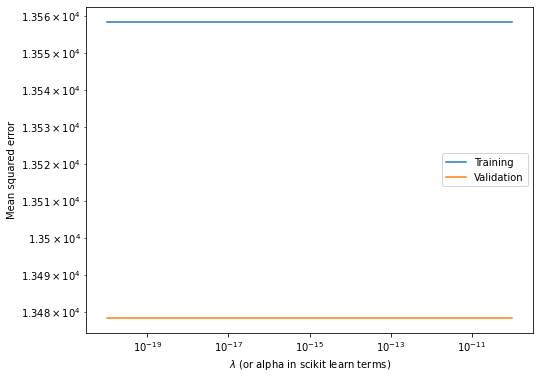

In [18]:
plot_L2_regression_performance()

In [96]:

train_pred = regression_model.predict(poly_xs)
print("Test set performance:")

print("MAE:",mean_absolute_error(ys, train_pred))
print("RMSE:",(mean_squared_error(ys, train_pred))**(0.5))  
print("R2:",r2_score(ys, train_pred))

Test set performance:
MAE: 63.83144389701851
RMSE: 110.21807597501105
R2: 0.24490505308905564


In [29]:
train_pred.max()

621.3639150372184